In [10]:
import numpy as np
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import math
from dwave.system import DWaveSampler
import minorminer as mm
import dwave.inspector

In [11]:
# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='pegasus'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage_system6.1 was selected.


# Create the embedding on the target graph

In [12]:
#create a target graph
T=nx.Graph()
T.add_edges_from(sampler.edgelist)
T.add_nodes_from(sampler.nodelist)

we try to embed Nchains disconnected periodic chains (called rings) of 12 qubits each. We use N=12 qubits chains so that we may compare with the results of the other IBM paper.

In [14]:
#create a source graph
S=nx.Graph()
#spin chain length
Nlen=12
#number of chains
Nchains=300

#define the nodes in base chain
base_nodes=[]
for i in range(Nlen):
    base_nodes.append(i)
base_nodes=np.array(base_nodes)
#generate all the nodes
allnodes=[]
for i in range(Nchains):
    allnodes.append(list(base_nodes+Nlen*i))
#all_nodes is a list of length Nchains, each element is a list of length Nlen

#add nodes to source graph
for i in range(len(allnodes)):
    for j in range(len(allnodes[i])):
        S.add_node(allnodes[i][j])

#define the edges
#loop over all the chains you are trying to embed
for i in range(len(allnodes)):
    #extract current list of sites for this ring
    spinlist=allnodes[i]
    for j in range(len(spinlist)-1):
        #add the nearest neighbor interaction as an edge
        S.add_edge(spinlist[j],spinlist[j+1])
    #add the final edge which completes the periodic chain
    S.add_edge(spinlist[len(spinlist)-1],spinlist[0])

In [15]:
#use minorminer to embed this graph (it is really Nchain disconnect graphs)
#this may take a while

cond=0
count=0

while (cond==0 and count<1000):
    print(count)

    embedding=mm.find_embedding(S,T)

    #here we make sure that minorminor didn't make any chains 
    biggerthan1=[]
    for value in embedding.values():
        if len(value)>1:
            biggerthan1.append(value)
    #if the embedding has any chains we reject it and try again
    if len(biggerthan1)>0:
        print(len(biggerthan1),"chains")
        cond=0
        count+=1
    if count==999:
        print("reached max iterations")   
    
    #if there are no chains it's a goood embedding
    if len(biggerthan1)==0:
        cond=1
    
print(embedding)

density = len(embedding)/sampler.properties["num_qubits"]

print("density of qubits used: {}".format(density))

0
2 chains
1
2 chains
2
3 chains
3
5 chains
4
9 chains
5
5 chains
6
3 chains
7
9 chains
8
4 chains
9
4 chains
10
{0: [2686], 1: [3224], 11: [3269], 2: [2731], 3: [2730], 4: [3059], 5: [2805], 6: [2806], 7: [3389], 8: [2761], 9: [2776], 10: [3254], 12: [2550], 13: [2938], 23: [2923], 14: [2520], 15: [2983], 16: [2535], 17: [2998], 18: [2999], 19: [2685], 20: [3029], 21: [2745], 22: [2924], 24: [268], 25: [5445], 35: [5461], 26: [194], 27: [209], 28: [5475], 29: [88], 30: [5490], 31: [118], 32: [5430], 33: [5431], 34: [374], 36: [5638], 37: [5637], 47: [2474], 38: [2339], 39: [2338], 40: [5397], 41: [2353], 42: [2368], 43: [5412], 44: [5427], 45: [2428], 46: [5532], 48: [1848], 49: [1849], 59: [3459], 50: [3715], 51: [1908], 52: [1907], 53: [3414], 54: [1772], 55: [3444], 56: [1802], 57: [3429], 58: [1742], 60: [2615], 61: [2630], 71: [4034], 62: [4064], 63: [4079], 64: [2691], 65: [4169], 66: [2631], 67: [4138], 68: [2526], 69: [4093], 70: [2585], 72: [5085], 73: [5070], 83: [116], 74: 

setting the J and h values on each used qubit

In [20]:
jval = -1
hval = -0.3

#set the coupler's interaction to -1 (FM) 
couplers={}
for edge in list(S.edges):
    spin0=edge[0]
    spin1=edge[1]
    qubit0=embedding.get(spin0)[0]
    qubit1=embedding.get(spin1)[0]
    couplers.update({(qubit0,qubit1):jval})

#set the magnetic fields  
hdict={}
#set initial state (+1)
initial={}
for node in list(S.nodes):
    spin0=node
    qubit0=embedding.get(spin0)[0]
    hdict.update({qubit0:hval})
    initial.update({qubit0:1.0})


info on the sampler properties

In [17]:
print("Chosen topology is:")
print(sampler.properties["topology"])
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {}".format(sampler.properties["annealing_time_range"]))

max_slope = 1.0/sampler.properties["annealing_time_range"][0]

print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
print("J range: {}".format(sampler.properties["j_range"]))
print("h range: {}".format(sampler.properties["h_range"]))


Chosen topology is:
{'type': 'pegasus', 'shape': [16]}
Maximum anneal-schedule points: 12
Annealing time range: [0.5, 2000.0]
Maximum slope allowed on this solver is 2.00.
J range: [-1.0, 1.0]
h range: [-4.0, 4.0]


# doing the run itself

note: parameters for the IBM-spectroscopy paper

J=1, h=0.3, g=0.25, t=30, dt=0.4

Time steps = 75
Circuits = 76

Shots = 8192

For the D-Wave machine, we have that at s=0.357, A(s)/B(s) = g/J = 0.25.

In [48]:
def run_specific_pause(sval, pausetime, num_reads, check_time):        
    #reverse anneal schedule (change as needed. but, must start with [0,1] and end at [tf,1])
    rev_sch=[[0.0, 1.0], [(1 - sval)/2, sval], [(1 - sval)/2 + pausetime, sval],
            [2*(1 - sval)/2 + pausetime, 1.0]]

    #print("reverse anneal schedule:")
    #print(rev_sch)
    #print("\n")
    mag_avg = 0
    mag_err = 0

    if check_time:
        print("pausetime = {}".format(pausetime))
        estimated_runtime = sampler.solver.estimate_qpu_access_time(num_qubits = len(initial), h=hdict,
            J=couplers,
            num_reads=num_reads,
            anneal_schedule=rev_sch,
            initial_state=initial,
            #reinitialize the initial state after reverse annealing                            
            reinitialize_state=True)    
        print("Estimate of {:.0f}us ({:.3f} s) on {}".format(estimated_runtime, estimated_runtime/10**6, sampler.solver.name)) 
    else:
        response = sampler.sample_ising(h=hdict,
        J=couplers,
        num_reads=num_reads,
        anneal_schedule=rev_sch,
        initial_state=initial,
        #reinitialize the initial state after reverse annealing                            
        reinitialize_state=True)

        #store the Z magnetization
        for i in range(len(response.record)):
            mag_avg += np.mean(response.record[i][0])
            mag_err += np.std(response.record[i][0])
        mag_avg = mag_avg/len(response.record)
        mag_err = mag_err/len(response.record)

    return mag_avg, mag_err
    

In [49]:
#set vals

sval=0.353
#pausetime = 15
pause_list = np.linspace(5, 40, 80) 
num_reads = 100

mag_vals = np.zeros(len(pause_list))
mag_errs = np.zeros(len(pause_list))

for j in range(len(pause_list)):
    mag_vals[j], mag_errs[j] = run_specific_pause(sval, pause_list[j], num_reads, False)
    print("done with s={}".format(pause_list[j]))
    print("\n")


done with s=5.0


done with s=5.443037974683544


done with s=5.886075949367089


done with s=6.329113924050633


done with s=6.772151898734177


done with s=7.215189873417721


done with s=7.658227848101266


done with s=8.10126582278481


done with s=8.544303797468354


done with s=8.987341772151899


done with s=9.430379746835442


done with s=9.873417721518987


done with s=10.316455696202532


done with s=10.759493670886076


done with s=11.20253164556962


done with s=11.645569620253164


done with s=12.088607594936708


done with s=12.531645569620252


done with s=12.974683544303797


done with s=13.41772151898734


done with s=13.860759493670885


done with s=14.30379746835443


done with s=14.746835443037973


done with s=15.189873417721518


done with s=15.632911392405063


done with s=16.075949367088604


done with s=16.518987341772153


done with s=16.962025316455694


done with s=17.40506329113924


done with s=17.848101265822784


done with s=18.29113924050633


done with

(0.99, 1.01)

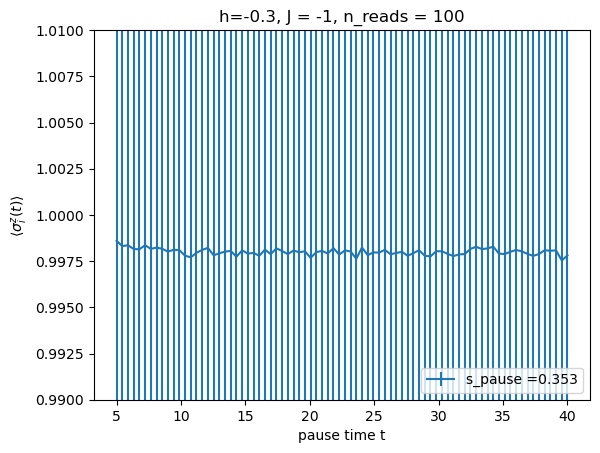

In [51]:

fig = plt.figure()
x = pause_list
y = mag_vals
yerr = mag_errs

plt.errorbar(x, y, yerr=yerr, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.ylabel(r"$\langle \sigma^z_i (t) \rangle$")
plt.xlabel("pause time t")
plt.legend(loc='lower right')
plt.ylim([0.99, 1.01])

#note - BIIIIG error bars!

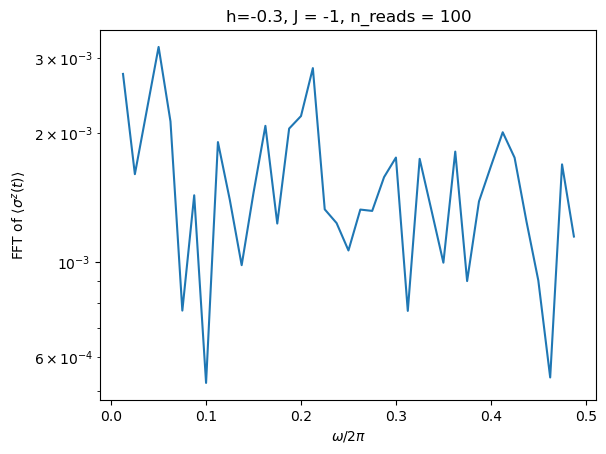

In [64]:
fftvals = np.abs(np.fft.fft(mag_vals))
y = fftvals[1:int(len(mag_vals)/2)]
x = [i/len(mag_vals) for i in range(1,int(len(mag_vals)/2))]
plt.plot(x, y, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.yscale('log')
plt.ylabel(r"FFT of $\langle  \sigma^z (t)\rangle$")
plt.xlabel(r"$\omega/2\pi$");